## 1. 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
from pandas import read_csv
from datetime import datetime
from pandas import DataFrame
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

## 2. 데이터 정제

In [57]:
# year, month, day, hour을 datetime으로 변환한 값을 index로 사용
def parse(x):
    #print(x)
    return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']],
                 index_col=0, date_parser=parse)

In [58]:
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [7]:
# No 변수 삭제
dataset.drop('No', axis=1, inplace=True)

In [8]:
dataset.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [10]:
# 변수, index 이름 재정의
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [11]:
# pollution 결측치 처리
dataset['pollution'].fillna(0, inplace=True)

dataset.isna().sum()

pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

In [12]:
# 첫 24시간 데이터 제외
dataset = dataset[24:]

In [13]:
# 데이터 저장
dataset.to_csv('pollution.csv')

## 3. 데이터 스케일링

In [16]:
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

In [18]:
# 범주형 데이터 wind_dir을 숫자로 encoding
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4]) #범주형 wind_dir 변수를 숫자로 인코딩 해 준다
values = values.astype('float32')

In [19]:
# minmaxscaler로 모든 값을 0~1 사이로 바꿈
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [22]:
scaled

array([[0.12977867, 0.35294122, 0.24590163, ..., 0.00229001, 0.        ,
        0.        ],
       [0.14889336, 0.36764708, 0.24590163, ..., 0.00381099, 0.        ,
        0.        ],
       [0.15995975, 0.4264706 , 0.22950819, ..., 0.00533197, 0.        ,
        0.        ],
       ...,
       [0.01006036, 0.2647059 , 0.26229507, ..., 0.41399646, 0.        ,
        0.        ],
       [0.00804829, 0.2647059 , 0.24590163, ..., 0.4208665 , 0.        ,
        0.        ],
       [0.01207243, 0.2794118 , 0.26229507, ..., 0.42621556, 0.        ,
        0.        ]], dtype=float32)

In [34]:
# t-1 시점데이터와 t 시점데이터를 하나의 행으로 가지는 데이터프레임을 reframed 변수로 선언

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    print('hello')
    print('a: ', cols)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #print('b: ', cols)
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    print('hello')
    print('c: ', cols)
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [35]:
reframed = series_to_supervised(scaled, 1, 1) #t-1시점,t시점 데이터를 한 행으로 둔다  

hello
a:  []
hello
c:  [              0         1         2         3         4         5         6  \
0           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1      0.129779  0.352941  0.245902  0.527273  0.666667  0.002290  0.000000   
2      0.148893  0.367647  0.245902  0.527273  0.666667  0.003811  0.000000   
3      0.159960  0.426471  0.229508  0.545454  0.666667  0.005332  0.000000   
4      0.182093  0.485294  0.229508  0.563637  0.666667  0.008391  0.037037   
...         ...       ...       ...       ...       ...       ...       ...   
43795  0.010060  0.264706  0.278689  0.763638  0.333333  0.385730  0.000000   
43796  0.008048  0.250000  0.278689  0.781818  0.333333  0.395659  0.000000   
43797  0.010060  0.264706  0.262295  0.781818  0.333333  0.405588  0.000000   
43798  0.010060  0.264706  0.262295  0.781818  0.333333  0.413996  0.000000   
43799  0.008048  0.264706  0.245902  0.781818  0.333333  0.420866  0.000000   

         7  
0      NaN  
1

In [36]:
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

## 4. 데이터 train/test split

In [52]:
values = reframed.values
n_train_hours = 365 * 24 #1년치 데이터만 가져온다
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

## 5. 모델 빌드

In [40]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [53]:
train_X.shape

(8760, 1, 8)

In [54]:
test_X.shape

(35039, 1, 8)

In [41]:
# 모델 훈련
history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
        validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
122/122 - 4s - loss: 0.0602 - val_loss: 0.0507 - 4s/epoch - 35ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0434 - val_loss: 0.0497 - 760ms/epoch - 6ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0245 - val_loss: 0.0412 - 765ms/epoch - 6ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0169 - val_loss: 0.0371 - 766ms/epoch - 6ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0157 - val_loss: 0.0252 - 747ms/epoch - 6ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0150 - val_loss: 0.0190 - 786ms/epoch - 6ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0149 - val_loss: 0.0176 - 782ms/epoch - 6ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0170 - 763ms/epoch - 6ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0167 - 760ms/epoch - 6ms/step
Epoch 10/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0162 - 760ms/epoch - 6ms/step
Epoch 11/50
122/122 - 1s - loss: 0.0148 - val_loss: 0.0155 - 766ms/epoch - 6ms/step
Epoch 12/50
122/122 - 1s - loss: 0.0147 - val_loss: 0.0154 - 751ms/epoch - 6ms/step
Epo

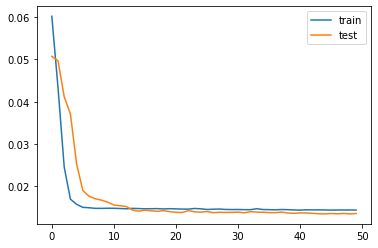

In [42]:

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

## 6. 예측 및 평가

In [55]:
from keras.layers import concatenate
from numpy import sqrt 

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))

1095/1095 [==============================] - 1s 1ms/step


In [56]:
print(rmse)

26.494965532377854
